In [1]:
Mounting my drive with google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
#importing the neccessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import np_utils
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras import layers, models, Model, optimizers, Sequential
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import VGG16

In [31]:
#using the unix .glob to find all images(.png files) in our path variable(i.e dataset)
path = Path('/content/drive/MyDrive/BCP_Image_Dataset')
file_path = list(path.glob(r'**/*.png'))

#extracing labels from the file path
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [4]:
#converting the filefath and labels to dataframes
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)

df = pd.concat([file_path, labels], axis=1)

df.columns = ['image', 'label']

df.head()

,image,label
0,/content/drive/MyDrive/BCP_Image_Dataset/malig...,malignant
1,/content/drive/MyDrive/BCP_Image_Dataset/malig...,malignant
2,/content/drive/MyDrive/BCP_Image_Dataset/malig...,malignant
3,/content/drive/MyDrive/BCP_Image_Dataset/malig...,malignant
4,/content/drive/MyDrive/BCP_Image_Dataset/malig...,malignant


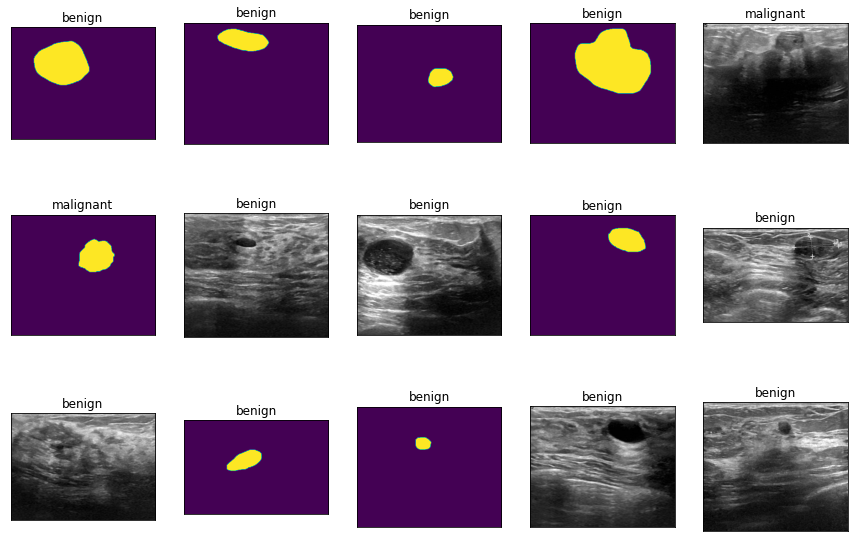

In [6]:
#using matplotlib to visualize some of our image data
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})

for ax in axes.flat:
    y = np.random.randint(1000)
    ax.imshow(plt.imread(df.image[y]))
    ax.set_title(df.label[y])
    
plt.show()

In [8]:
#using train test split to split our dataframe into training, validation and testing
x_train, x_test = train_test_split(df, test_size=.2, random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.1, random_state=30)

In [9]:
#printing the shape of our train, validation and testing data
print('Shape of Train data is ', x_train.shape)
print('Shape of Test data is ', x_test.shape)
print('Shape of Validation data is ', x_val.shape)

Shape of Train data is  (684, 2)
Shape of Test data is  (191, 2)
Shape of Validation data is  (76, 2)


In [10]:
#using the imagedatagenerator to create augmentation and preprocessing for our images.
train_gen =  ImageDataGenerator(rescale=1./255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest')

val_gen = ImageDataGenerator(rescale=1./225)

test_gen = ImageDataGenerator(rescale=1./225)

In [14]:
#applying the augmentation and preprocessing created earlier to our images
train_data = train_gen.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', 
                                           target_size=(224, 224), color_mode='rgb', class_mode='binary', shuffle=True)

val_data = val_gen.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', 
                                           target_size=(224, 224), color_mode='rgb', class_mode='binary', shuffle=True)
test_data = test_gen.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', 
                                           target_size=(224, 224), color_mode='rgb', class_mode='binary', shuffle=True)

Found 684 validated image filenames belonging to 2 classes.
Found 76 validated image filenames belonging to 2 classes.
Found 191 validated image filenames belonging to 2 classes.


In [12]:
#printing batch size, image size and output size
print("Batch size for Input image: ", train_data[0][0].shape)
print("Batch size for Output image: ", train_data[0][1].shape)
print("Image size of the first image: ", train_data[0][0][0].shape)
print('Output of the first image: ', train_data[0][0][1].shape)

Batch size for Input image:  (32, 224, 224, 3)
Batch size for Output image:  (32,)
Image size of the first image:  (224, 224, 3)
Output of the first image:  (224, 224, 3)


In [13]:
#initializing our vgg16 model with imagenet weights
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [15]:

# Freeze four convolution blocks
for layer in vgg_model.layers[:15]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [16]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x) 
transfer_model = Model(inputs=vgg_model.input, outputs=x)


In [18]:
#setting up callbacks to be used during model training
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=3, verbose=1, mode='max', min_lr=5e-5)
checkpoint = ModelCheckpoint('vgg16_finetune.h15', monitor= 'val_accuracy', mode= 'max', save_weights_only=True, save_best_only = True, verbose= 1)
earlystop = EarlyStopping(monitor = 'val_accuracy', mode="max", patience=5, verbose=1, restore_best_weights= True)

In [19]:
#setting learning rate, compiling model and fitting the model on our training and testing data
learning_rate= 5e-5
transfer_model.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])
history = transfer_model.fit(train_data, batch_size = 32, epochs=25, validation_data=val_data, callbacks=[lr_reduce,checkpoint, earlystop])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/25
22/22 [==============================] - ETA: 0s - loss: 0.5361 - accuracy: 0.7442 
Epoch 1: val_accuracy improved from -inf to 0.82895, saving model to vgg16_finetune.h15
INFO:tensorflow:Assets written to: vgg16_finetune.h15/assets
22/22 [==============================] - 494s 22s/step - loss: 0.5361 - accuracy: 0.7442 - val_loss: 0.3073 - val_accuracy: 0.8289 - lr: 5.0000e-05
Epoch 2/25
22/22 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8436 
Epoch 2: val_accuracy improved from 0.82895 to 0.93421, saving model to vgg16_finetune.h15
INFO:tensorflow:Assets written to: vgg16_finetune.h15/assets
22/22 [==============================] - 476s 22s/step - loss: 0.3217 - accuracy: 0.8436 - val_loss: 0.2141 - val_accuracy: 0.9342 - lr: 5.0000e-05
Epoch 3/25
22/22 [==============================] - ETA: 0s - loss: 0.2699 - accuracy: 0.8772 
Epoch 3: val_accuracy did not improve from 0.93421
22/22 [==============================] - 473s 22s/step - loss: 0.26

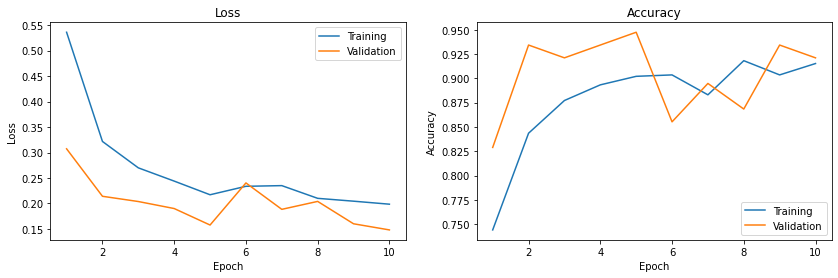

In [21]:
#visualizing our accuracy and loss
history = history.history
n_epochs = len(history['loss'])

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

In [22]:
#evaluating the model on our test dataset
transfer_model.evaluate(test_data)

6/6 [==============================] - 99s 16s/step - loss: 0.2620 - accuracy: 0.9162


[0.26204580068588257, 0.9162303805351257]

In [25]:
#downloading the model as a pickle file
def download_history():
  import pickle
  from google.colab import files

  with open('BCP_VGG16.pkl', 'wb') as f:
    pickle.dump(history, f)

  files.download('BCP_VGG16.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
#converting the model to tflite format and downloading it
def download_tflite():
  from google.colab import files
  transfer_model.save('/content/BCP_VGG16')
  model = tf.keras.models.load_model('/content/BCP_VGG16')
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  tflite_model = converter.convert() 

  open("BCP_TFLITE_VGG16.tflite", "wb").write(tflite_model)

  files.download('BCP_TFLITE_VGG16.tflite')

download_tflite()

INFO:tensorflow:Assets written to: /content/BCP_VGG16/assets


INFO:tensorflow:Assets written to: /content/BCP_VGG16/assets


INFO:tensorflow:Assets written to: /tmp/tmpuwxfyh08/assets


INFO:tensorflow:Assets written to: /tmp/tmpuwxfyh08/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>